This notebook shows sensitivity tests to the restriction of the free parameters of the Antarctic ice discharge parametrization. We a) restrict the fast discharge rate to below 5mm, b) to above 10mm, and we c) allow only for threshold temperatures above 3°C above the 1850 reference. See the corresponding RCP85 percentiles for the sea level contribution in 2100 below. We also show sample parameter plots for c).

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

In [20]:
import os, sys
import glob
from matplotlib import cm
import netCDF4 as nc
import collections
import dimarray as da
import itertools
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy import optimize
import scipy.integrate
import mystic

# custom imports 
# create a subfolder fast_ant_sid that holds load_data.py and 
# an empty file __init__.py
if "../" not in sys.path: sys.path.append("../")
import fast_ant_sid.load_data as ld; reload(ld)
import fast_ant_sid.fast_ant_sid as fas; reload(fas)

plt.rcParams['figure.figsize'] = 10,6
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.major.pad'] = 10
plt.rcParams['font.sans-serif'] = [u"Liberation Sans"] + plt.rcParams['font.sans-serif']
plt.rcParams['svg.fonttype'] = 'none'

pd.options.display.float_format = '{:.2f}'.format

In [3]:
magicc_data_path = "../data/magicc_gmts"
magicc_gmt = collections.OrderedDict()
for scen in ["RCP26","RCP45","RCP85"]:
    magicc_gmt[scen] = ld.read_magicc_output(
        magicc_data_path+"/DAT_SURFACE_TEMP_"+scen+".OUT")["GLOBAL"]

forcing = {scen:magicc_gmt[scen] for scen in magicc_gmt}

In [14]:
def get_fitted_slr(parameters, max_volume_to_loose):

    slr_fitted = {}

    for scen in ["RCP26","RCP45","RCP85"]:

        slr_fitted[scen] = collections.OrderedDict()

        for index, params in parameters.iterrows():

            slr = fas.calc_solid_ice_discharge(forcing[scen].values, params.values,
                                       max_volume_to_lose,temp_sensitivity=fas.square)
            slr = pd.DataFrame(slr,index=forcing[scen].index,
                                                   columns=["slr_projected"])
            slr_fitted[scen][index] = slr - slr.loc[1950]
            
    return slr_fitted

def dp16_id_to_int(df):
    return [np.int(st[0:-3]) for st in df.index]

In [ ]:
# determine maximum volume one time, (taken most sensitive run in year 2500)
# max_volume_to_lose = dp16_slr_mean["RCP85PIT"].max().max()
# we here use the hardcoded value, which is equivalent to dp16_slr_mean["RCP85PIT"].max().max()
max_volume_to_lose = 17560. # in mm

In [22]:
# Our reference values for the quadratic temperature sensitivity
# Show the percentiles for our RCP85 projection in 2100 in mm / yr

parameters_ens = pd.read_csv("../data/parameters/parameters_quadratic.csv",index_col=0)
# make index same datatype as when determined from DP16 files.
parameters_ens.index = [str(idx) for idx in parameters_ens.index]

slr_fitted = get_fitted_slr(parameters_ens, max_volume_to_lose)
projection_quantiles = fas.get_quantiles(slr_fitted)
## Quantiles for RCP26 scenario for the year 2100, relative to 1950, in mm
pd.DataFrame(projection_quantiles["RCP85"].loc[2100,:]).T

,0.05,0.1667,0.5,0.8333,0.95
2100,437.01,569.18,888.75,1405.99,1579.16


In [24]:
# Restrict the fast rate to below 5 mm/yr
# Show the percentiles for our RCP85 projection in 2100 in mm / yr

parameters_ens = pd.read_csv("../data/parameters/parameters_fastrate_smaller_5mm.csv",index_col=0)
# make index same datatype as when determined from DP16 files.
parameters_ens.index = [str(idx) for idx in parameters_ens.index]

slr_fitted = get_fitted_slr(parameters_ens, max_volume_to_lose)
projection_quantiles = fas.get_quantiles(slr_fitted)
## Quantiles for RCP26 scenario for the year 2100, relative to 1950, in mm
pd.DataFrame(projection_quantiles["RCP85"].loc[2100,:]).T

,0.05,0.1667,0.5,0.8333,0.95
2100,415.08,585.12,728.56,1298.93,1568.77


In [25]:
# Restrict the fast rate to higher 10 mm/yr
# Show the percentiles for our RCP85 projection in 2100 in mm / yr

parameters_ens = pd.read_csv("../data/parameters/parameters_fastrate_larger_10mm.csv",index_col=0)
# make index same datatype as when determined from DP16 files.
parameters_ens.index = [str(idx) for idx in parameters_ens.index]

slr_fitted = get_fitted_slr(parameters_ens, max_volume_to_lose)
projection_quantiles = fas.get_quantiles(slr_fitted)
## Quantiles for RCP26 scenario for the year 2100, relative to 1950, in mm
pd.DataFrame(projection_quantiles["RCP85"].loc[2100,:]).T

,0.05,0.1667,0.5,0.8333,0.95
2100,451.20,535.61,765.01,1392.09,1585.98


In [26]:
# Allow for threshold temperature only above 3°C relative to preindustrial
# Show the percentiles for our RCP85 projection in 2100 in mm / yr

parameters_ens = pd.read_csv("../data/parameters/parameters_Tthresh_above_3degC.csv",index_col=0)
# make index same datatype as when determined from DP16 files.
parameters_ens.index = [str(idx) for idx in parameters_ens.index]

slr_fitted = get_fitted_slr(parameters_ens, max_volume_to_lose)
projection_quantiles = fas.get_quantiles(slr_fitted)
## Quantiles for RCP26 scenario for the year 2100, relative to 1950, in mm
pd.DataFrame(projection_quantiles["RCP85"].loc[2100,:]).T

,0.05,0.1667,0.5,0.8333,0.95
2100,360.12,558.10,713.84,1291.43,1570.37


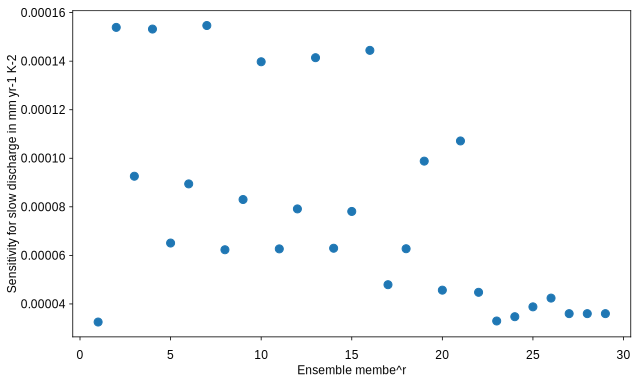

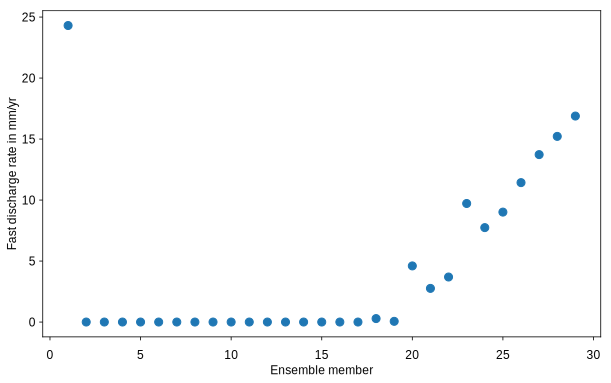

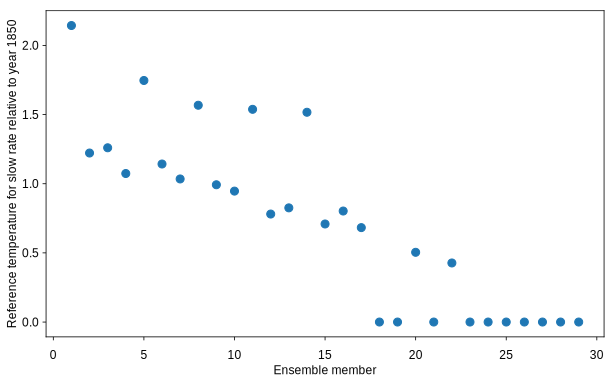

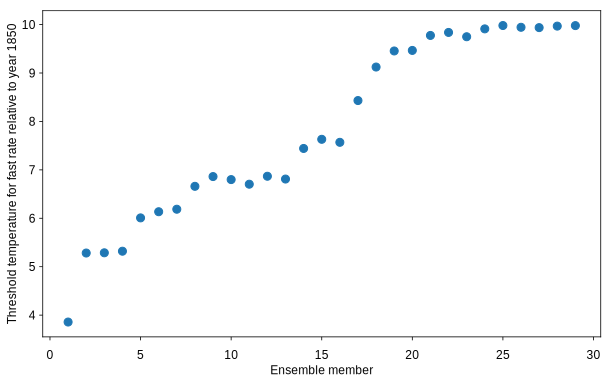

In [27]:
# Allow for threshold temperature only above 3°C relative to preindustrial

fig = plt.figure()
plt.plot(dp16_id_to_int(parameters_ens["sid_sens"]), parameters_ens["sid_sens"],"o")
plt.xlabel("Ensemble member")
l1 = plt.ylabel("Sensitivity for slow discharge in mm yr-1 K-2")

fig = plt.figure()
plt.plot(dp16_id_to_int(parameters_ens["fastrate"]), parameters_ens["fastrate"],"o")
plt.xlabel("Ensemble member")
l1 = plt.ylabel("Fast discharge rate in mm/yr")

fig = plt.figure()
plt.plot(dp16_id_to_int(parameters_ens["temp0"]), parameters_ens["temp0"],"o")
plt.xlabel("Ensemble member")
l1 = plt.ylabel("Reference temperature for slow rate relative to year 1850")

fig = plt.figure()
plt.plot(dp16_id_to_int(parameters_ens["temp_thresh"]),parameters_ens["temp_thresh"],"o")
plt.xlabel("Ensemble member")
l1 = plt.ylabel("Threshold temperature for fast rate relative to year 1850")